<a href="https://colab.research.google.com/github/yiihuang/Deep_Learning/blob/master/conv_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Main imports**

In [ ]:
import math
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

**Params**

In [ ]:
batch_size  = 8
n_channels  = 3
latent_size = 512

**Import dataset**

In [ ]:
# helper function to make getting another batch of data easier
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10('data', train=True, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.Resize((32,32)),
        torchvision.transforms.ToTensor(),
    ])),
    shuffle=True, batch_size=batch_size, drop_last=True
)
class_names = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

train_iterator = iter(cycle(train_loader))

**View some of the test dataset**

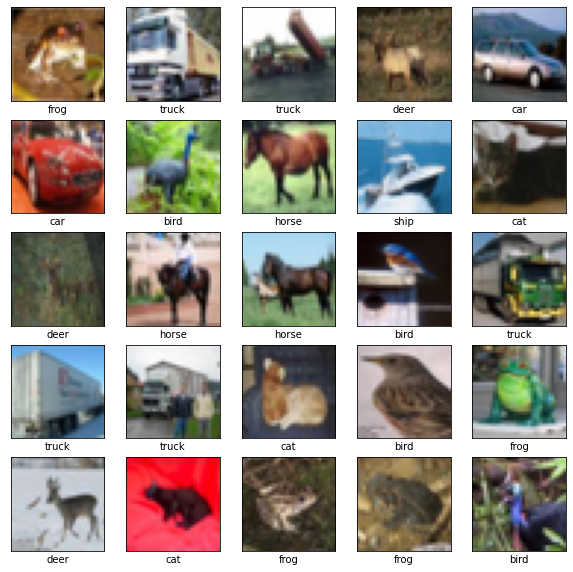

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    if n_channels == 1:
        plt.imshow(train_loader.dataset[i][0].repeat(3,1,1).permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
    else:
        plt.imshow(train_loader.dataset[i][0].permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
    plt.xlabel(class_names[train_loader.dataset[i][1]])

**Define a simple convolutional autoencoder**

In [ ]:
# simple block of convolution, batchnorm, and leakyrelu
class Block(nn.Module):
    def __init__(self, in_f, out_f):
        super(Block, self).__init__()
        self.f = nn.Sequential(
            nn.Conv2d(in_f, out_f, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_f),
            nn.LeakyReLU(inplace=True)
        )
    def forward(self,x):
        return self.f(x)

# define the model
class Autoencoder(nn.Module):
    def __init__(self, f=16):
        super().__init__()

        self.encode = nn.Sequential(
            Block(n_channels, f),
            nn.MaxPool2d(kernel_size=(2,2)), # output = 16x16
            Block(f  ,f*2),
            nn.MaxPool2d(kernel_size=(2,2)), # output = 8x8
            Block(f*2,f*4),
            nn.MaxPool2d(kernel_size=(2,2)), # output = 4x4
            Block(f*4,f*4),
            nn.MaxPool2d(kernel_size=(2,2)), # output = 2x2
            Block(f*4,f*4),
            nn.MaxPool2d(kernel_size=(2,2)), # output = 1x1
            Block(f*4,latent_size),
        )

        self.decode = nn.Sequential(
            nn.Upsample(scale_factor=2), # output = 2x2
            Block(latent_size,f*4),
            nn.Upsample(scale_factor=2), # output = 4x4
            Block(f*4,f*4),
            nn.Upsample(scale_factor=2), # output = 8x8
            Block(f*4,f*2),
            nn.Upsample(scale_factor=2), # output = 16x16
            Block(f*2,f  ),
            nn.Upsample(scale_factor=2), # output = 32x32
            nn.Conv2d(f,n_channels, 3,1,1),
            nn.Sigmoid()
        )

A = Autoencoder().to(device)
print(f'> Number of autoencoder parameters {len(torch.nn.utils.parameters_to_vector(A.parameters()))}')
optimiser = torch.optim.Adam(A.parameters(), lr=0.001)
epoch = 0

> Number of autoencoder parameters 750147


**Main training loop**

loss tensor(0.0314, device='cuda:0', grad_fn=<MeanBackward0>)


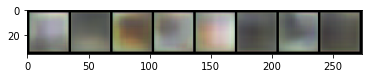

loss tensor(0.0433, device='cuda:0', grad_fn=<MeanBackward0>)


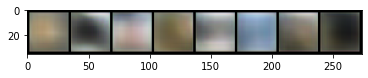

loss tensor(0.0300, device='cuda:0', grad_fn=<MeanBackward0>)


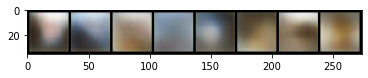

loss tensor(0.0357, device='cuda:0', grad_fn=<MeanBackward0>)


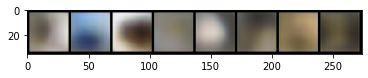

loss tensor(0.0293, device='cuda:0', grad_fn=<MeanBackward0>)


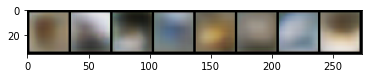

loss tensor(0.0342, device='cuda:0', grad_fn=<MeanBackward0>)


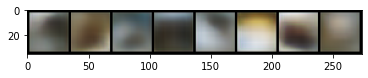

loss tensor(0.0240, device='cuda:0', grad_fn=<MeanBackward0>)


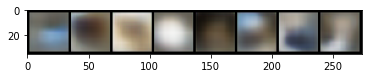

loss tensor(0.0186, device='cuda:0', grad_fn=<MeanBackward0>)


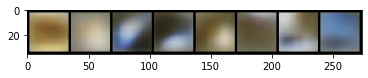

loss tensor(0.0338, device='cuda:0', grad_fn=<MeanBackward0>)


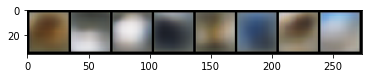

loss tensor(0.0274, device='cuda:0', grad_fn=<MeanBackward0>)


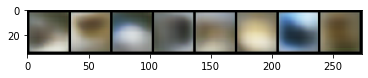

In [ ]:
# training loop
while (epoch<10):

    # array(s) for metrics
    loss_arr = np.zeros(0)

    # iterate over some of the train dateset
    for i in range(100):

        # sample x from the dataset
        x,t = next(train_iterator)
        x,t = x.to(device), t.to(device)

        # do the forward pass with mean squared error
        z = A.encode(x)
        x_hat = A.decode(z)
        loss = ((x-x_hat)**2).mean()

        # backpropagate to compute the gradients of the loss w.r.t the parameters and optimise
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        # collect stats
        loss_arr = np.append(loss_arr, loss.item())

    # sample (autoencoders are not good at this)
    z = torch.randn_like(z)
    g = A.decode(z)

    # plot some examples
    print('loss ' + str(loss.mean()))
    plt.grid(False)
    plt.imshow(torchvision.utils.make_grid(g).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
    plt.show()
    plt.pause(0.0001)

    epoch = epoch+1